In [171]:
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using ForneyLab
using NARMAX
import ProgressMeter
using CSV
using DataFrames
using Statistics

In [3]:
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision, Gamma

In [4]:
include("../src/polynomial.jl")
include("../src/data.jl");

In [5]:
delay_y, delay_u, delay_e = 3, 3, 3
order_h = delay_e + 1 # e_k, e_{k-1}, e_{k-2}
order_u = delay_u + 1 # u_k, u_{k-1}, u_{k-2}

poly_order = 2
output_ = ϕ(randn(delay_y + delay_u + delay_e + 1), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))


42-element Vector{Float64}:
  1.0
 -0.1641522003679391
  0.026945944885636022
  1.656417719434945
 -0.2719046133736898
  2.7437196612580643
 -1.1518213039249197
  0.1890740014699443
 -1.9078972174439002
  1.3266923161753021
 -0.40610153038198543
  0.06666245978499037
 -0.6726737708143693
  ⋮
 -0.8492070431628587
  0.5905121348808929
  0.20819885937783947
  0.7849726099945957
  0.6237192549928712
  0.2628375676787397
 -0.37093213799931996
  0.13759065100074655
 -0.9273773371557434
  0.8600287254700775
  0.9118582533942569
  0.8314854742832247

In [6]:
function model_specification(ϕ; M1=M1, M2=M2, M3=M3, N=N)

    graph = FactorGraph()

    # Observed variables
    @RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M1,))
    @RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M2,))
    @RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3,))
    @RV u_k; placeholder(u_k, :u_k)

    # Time-invariant parameters
    @RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
    @RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(N,)), placeholder(:w_θ, dims=(N,N)))

    # Likelihood
    @RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)
    placeholder(y_k, :y_k)

    q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
    algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
    return algorithmSourceCode(algorithm, free_energy=true)
    
end

model_specification (generic function with 1 method)

In [7]:
function experiment_FEM(input_trn, output_trn, input_tst, output_tst, ϕ, priors; M1=1, M2=1, M3=1, N=3, num_iters=5, computeFE=false)

    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    "Inference execution"

    # Extract prior parameters
    θ_k = priors["θ"]
    τ_k = priors["τ"]

    # Initialize marginals
    marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_k[1], w=θ_k[2]),
                     :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

    # Preallocate free energy array
    Fq = zeros(T_trn-maxM, num_iters)

    # Preallocate parameter arrays
    params_θ = (zeros(T_trn-maxM,N), zeros(T_trn-maxM,N,N))
    params_τ = (zeros(T_trn-maxM,1), zeros(T_trn-maxM,1))

    # Preallocate prediction arrays
    predictions = (zeros(T_trn,), zeros(T_trn,))
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)
        
        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        # predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

        # Compute prediction error
        errors[k] = output_trn[k] - predictions[1][k]
        
        # Set data 
        data = Dict(:y_k => output_trn[k],
                    :u_k => input_trn[k],
                    :u_kmin1 => u_kmin1,
                    :y_kmin1 => y_kmin1,
                    :e_kmin1 => e_kmin1,
                    :m_θ => θ_k[1],
                    :w_θ => θ_k[2],
                    :a_τ => τ_k[1],
                    :b_τ => τ_k[2])
        
        # Iterate updates
        for n = 1:num_iters
            
            # Compute free energy
            if computeFE
                Fq[ii,n] = freeEnergy(data,marginals)
            end
            
            # Update parameters
            stepθ!(data, marginals)
            stepτ!(data, marginals)
            
        end 
        
        # Update params
        θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
        τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
        
        # Store params
        params_θ[1][ii,:] = θ_k[1]
        params_θ[2][ii,:,:] = θ_k[2]
        params_τ[1][ii] = τ_k[1]
        params_τ[2][ii] = τ_k[2]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = (zeros(T_tst,), zeros(T_tst,))
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        # predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])

        # Update error
        errors[k] = output_tst[k] - predictions[1][k]
        
    end

    "Simulation"

    # Prepare array
    simulations = (zeros(T_tst,), zeros(T_tst,))

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[1][k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[1][k] = θ_k[1]'*ϕx
        
        # simulations[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[1][maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

    if computeFE
        return RMS_sim, RMS_prd, Fq
    else
        return RMS_sim, RMS_prd, simulations, predictions, θ_k[1]
    end
end

experiment_FEM (generic function with 1 method)

In [8]:
function experiment_RLS(input_trn, output_trn, input_tst, output_tst, ϕ; M1=1, M2=1, M3=1, N=1, λ=1.00)
    
    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    # Parameters
    P = λ.*Matrix{Float64}(I,N,N)
    w_k = zeros(N,)

    # Preallocate prediction array
    predictions = zeros(T_trn,)
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)

        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        # Update data vector
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        
        # Update weights
        α = output_trn[k] - w_k'*ϕx 
        g = P*ϕx*inv(λ + ϕx'*P*ϕx)
        P = inv(λ)*P - g*ϕx'*inv(λ)*P
        w_k = w_k + α*g
        
        # Prediction
        predictions[k] = w_k'*ϕx
        errors[k] = output_trn[k] - predictions[k]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = zeros(T_tst,)
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[k] = w_k'*ϕx

        # Update error
        errors[k] = output_tst[k] - predictions[k]
        
    end

    "Simulation"

    # Prepare array
    simulations = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[k] = w_k'*ϕx
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[maxM+1:end] - output_tst[maxM+1:end]).^2))

    return RMS_sim, RMS_prd, simulations, predictions, w_k
end

experiment_RLS (generic function with 1 method)

### Real dataset

In [9]:

df = DataFrame(CSV.File("../datasets/cascadedtanks/dataBenchmark.csv"))[1:1000, :];
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = input_trn
# input_val = input_val

### Synthetic dataset

In [138]:
# find order
M1, M2, M3 = 3, 3, 3
poly_order = 2
options = Dict("na"=>M1, "nb"=>M2, "ne"=>M3, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false)

PΦ = gen_combs(options)
ϕ_fl(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)]
N = size(PΦ,2)

42

In [156]:
seed = 42
syn_input, syn_noise, syn_output, η_true = generate_data(seed, ϕ, options, w_true=1e3, scale_coef=0.2);

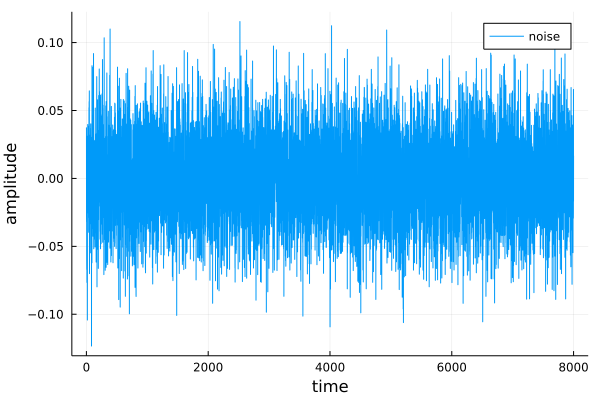

In [157]:
# Visualize noise
plot(syn_noise, xlabel="time", ylabel="amplitude", label="noise")

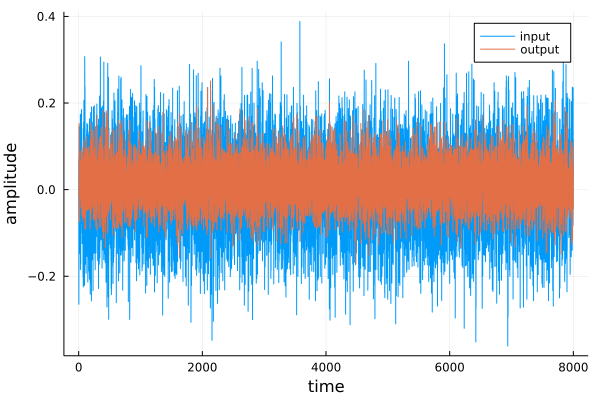

In [172]:
# Plot both input and outputs
plot(syn_input, label="input")
plot!(syn_output, xlabel="time", ylabel="amplitude", label="output")

In [173]:
train_size = 1000+order_u
test_size = 1000+order_u

u_train = syn_input[1:train_size]
u_val = syn_input[train_size + 1:train_size + test_size]
y_train = syn_output[1:train_size]
y_val = syn_output[train_size + 1:train_size + test_size]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = u_train
# input_val = u_val

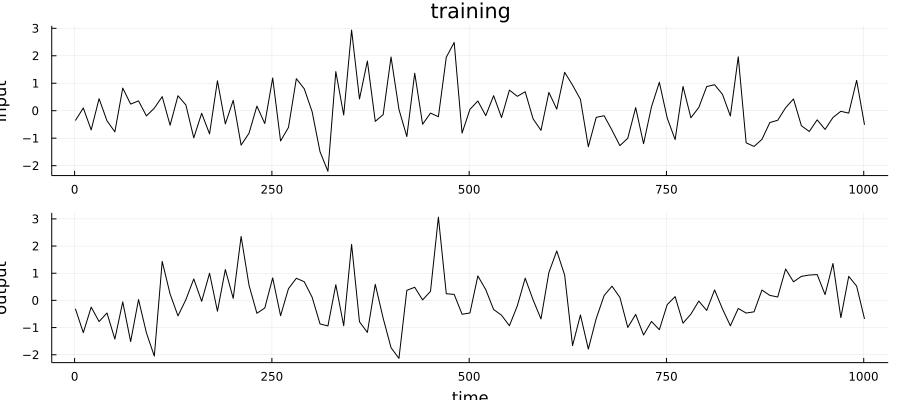

In [174]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

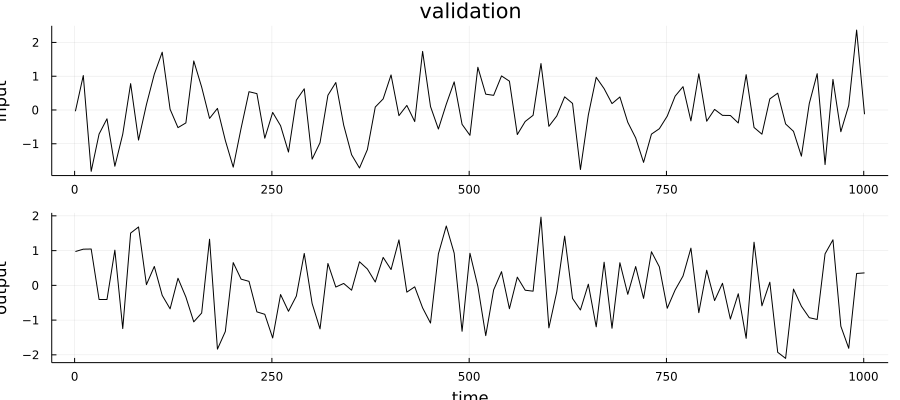

In [175]:
n = 10
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

# find order
seed = 42

delay_y, delay_u, delay_e = 3, 3, 3
order_h = delay_e + 1 # e_k, e_{k-1}, e_{k-2}

poly_order = 2

output__ = ϕ(randn(sum([delay_u, delay_y, order_h])), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))
full_order = length(output__)

### prepare training/test sets 

In [176]:
# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size-order_u], observations[1:train_size-order_u], controls[1:train_size-order_u];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size-order_u], observations[1:test_size-order_u], controls[1:test_size-order_u];

In [164]:
# Specify model and compile update functions
source_code = model_specification(ϕ_fl, M1=M1, M2=M2, M3=M3, N=N)
eval(Meta.parse(source_code))

freeEnergy (generic function with 1 method)

In [187]:
println(source_code)

begin

function stepτ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_τ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_τ]))
messages[2] = ruleVariationalNARMAXIn6PPPPPPN(ϕ_fl, ProbabilityDistribution(Univariate, PointMass, m=data[:y_k]), marginals[:θ], ProbabilityDistribution(Univariate, PointMass, m=data[:u_k]), ProbabilityDistribution(Multivariate, PointMass, m=data[:u_kmin1]), ProbabilityDistribution(Multivariate, PointMass, m=data[:y_kmin1]), ProbabilityDistribution(Multivariate, PointMass, m=data[:e_kmin1]), nothing)

marginals[:τ] = messages[1].dist * messages[2].dist

return marginals

end

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_θ]), ProbabilityDistributio

In [183]:
# Initialize priors
priors = Dict("θ" => (zeros(N,), Matrix{Float64}(I,N,N)), 
              "τ" => (1.0, 1.0))
prior_mτ = priors["τ"][1] ./ priors["τ"][2]  

1000.0

In [184]:
rms_sim, rms_pred, sim, pred, coefs = experiment_FEM(input_trn, output_trn, input_val, output_val, ϕ_fl, priors, M1=M1, M2=M2, M3=M3, N=N, num_iters=20, computeFE=false)

(0.9545060347005729, 0.8900918834970553, ([0.0, 0.0, 0.0, -0.17126204505899115, -0.10154403159681766, -0.1386102181040093, -0.06618838495285187, 0.40266404200184114, -1.718505792227104, 0.08738699205436692  …  0.1698530720191318, -0.8653879964861282, 0.08760015977073078, -0.4703782259946799, 0.46918119406585485, 0.15959583977122568, 0.28719256507344526, -0.6599899286463567, -0.24083719923229302, -0.46627738634669935], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ([0.0, 0.0, 0.0, -0.17126204505899115, -0.05528407819645358, -0.27229440996631277, -0.05153389932301303, 1.3790922861069317, -1.5561826091328352, 0.5045002372547343  …  1.0530875850908836, -1.1511813175813261, 0.7109976973948514, -0.43936092438935953, 0.25844243849602233, -0.19280025354570574, 0.4578265541097745, -0.4593478745840271, -0.27594588625370103, -0.3080278522012111], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

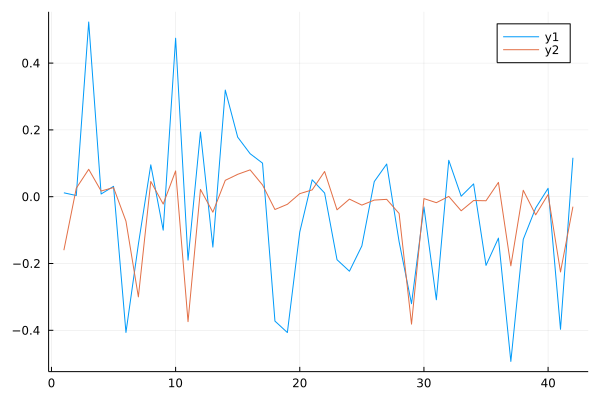

In [167]:
plot(η_true)
plot!(coefs)


In [168]:
println(coefs)

[-0.16012988069797296, 0.025524227698047366, 0.08209887737271748, 0.017069582558796752, 0.027417780916891645, -0.07316287038565024, -0.2998651694551303, 0.045637515202756204, -0.02194869825196957, 0.0772732288652755, -0.37404184581438654, 0.0219781227536519, -0.046339113942821995, 0.04910925465182303, 0.06707296413744515, 0.08040770576606047, 0.03513460119141363, -0.038287439755747714, -0.022722167848336534, 0.009249341536240895, 0.020456900576978857, 0.07553348633357408, -0.039219241978414476, -0.007169160850531174, -0.025090733546447724, -0.010055137527854354, -0.007854978326197977, -0.05013032516897526, -0.38145710044432324, -0.005597732134007366, -0.01782155150503298, 0.000953879146870347, -0.04214246337866256, -0.01139210392004296, -0.012066222153279127, 0.04287338518049182, -0.20701207835477564, 0.01930032505535397, -0.05424992819417463, 0.00661761681144234, -0.22525212410344628, -0.02979377567488982]


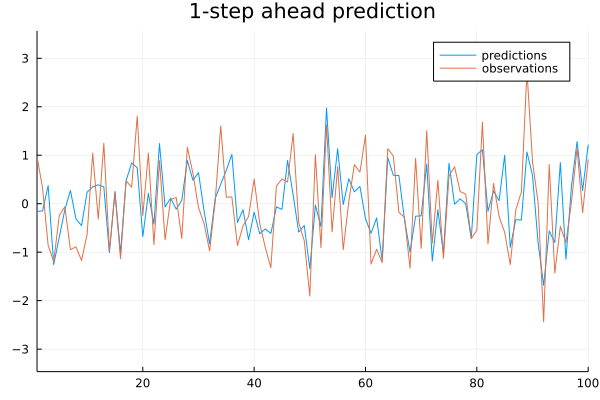

In [169]:
plot(pred[1][4:end], label="predictions")
plot!(output_val[1:end], xlims=(1, 100), title="1-step ahead prediction", label="observations")

In [170]:
rms_sim, rms_pred, sim, pred, coefs = experiment_RLS(input_trn, output_trn, input_val, output_val, ϕ_fl, M1=M1, M2=M2, M3=M3, N=N, λ=1.0)

(0.8067234874215826, 0.6221155649389202, [0.0, 0.0, 0.0, -0.15262058431731798, -0.07879093502189538, 0.6026326528957029, -0.9272061717148392, -0.5310320475009749, -1.0234950884161214, 0.08720515077442738  …  0.4998883868206454, -0.3214042592310595, 0.3207515687380633, -0.29833433604648146, -0.1654027978104003, -0.11693235580502748, 0.06775514741265519, -0.34400163710867204, -0.22652422134772926, -0.367362187788715], [0.0, 0.0, 0.0, -0.15262058431731798, -0.3240467225187605, 0.3287643867752464, -1.2756162861408533, -0.7630933119962889, -0.09367814929907989, 0.22875408619291643  …  0.2582106335622483, -0.26659532399676217, 0.5102943444103539, -0.4492077080220216, -0.1654987337913556, 0.11905959147293736, 0.23790851685990047, -0.21478264356429955, -1.0770289915148654, -0.7226894693421787], [-0.15190551508879543, 0.02234353425454075, 0.08792524510224745, 0.013991954785123956, 0.03302797269721149, -0.07544344777668947, -0.3018339178050398, 0.03971872734828318, -0.02809527735997167, 0.072032

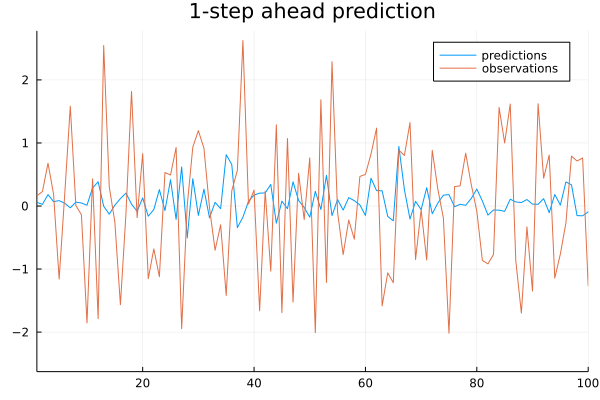

In [134]:
plot(sim[4:end], label="predictions")
plot!(output_val, xlims=(1, 100), title="1-step ahead prediction", label="observations")